In [1]:
import numpy as  np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Matérn con $K_\nu$

In [2]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

Observations points

In [3]:
d = 2
n = 500
# m = 300
m = n
X_1 = np.random.uniform(0, n, (n,d))
# X_2 = np.random.uniform(0, n, (m,d))
X_2 = X_1

Parameters

In [4]:
nu_1 = 3/2
theta_1 = 50/n

nu_2 = 5/2
theta_2 = 40/n

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [5]:
rho_12

0.7745966692414835

In [ ]:
# set parameters paper
nu_1 = 3/2
theta_1 = 1

nu_2 = 1/2
theta_2 = 0.2

nu_12 = 1
theta_12 = 0.6
rho_12 = 0.5

Models

In [6]:
matern_1 = matern_model(theta_1, nu_1)
matern_2 = matern_model(theta_2, nu_2)
matern_12 = matern_model(theta_12, nu_12)

Covariance matrices

In [7]:
sigma_1 = np.nan_to_num(matern_1(cdist(X_1,X_1)), nan=1)
sigma_2 = np.nan_to_num(matern_2(cdist(X_2,X_2)), nan=1)
sigma_12 = rho_12 * np.nan_to_num(matern_12(cdist(X_1,X_2)), nan=1)

In [8]:
sigma = np.block([[sigma_1, sigma_12],
                  [sigma_12.T, sigma_2]])

In [9]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+m))

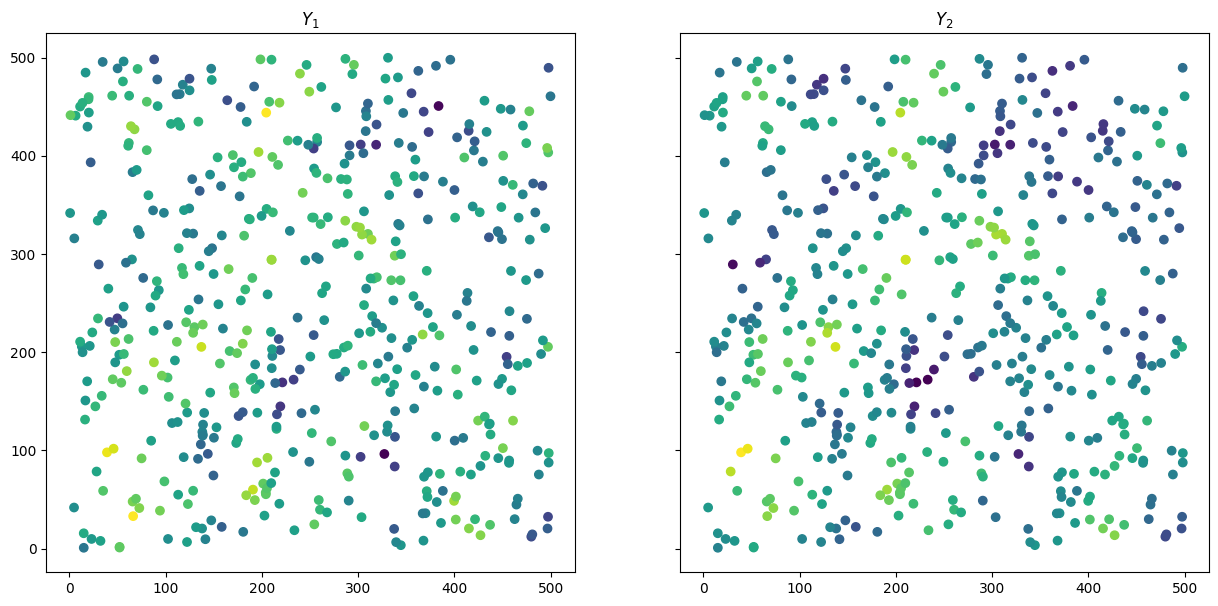

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,7))

ax1.scatter(X_1[:,0], X_1[:,1], c=Y[:n])
ax1.set_title(r'$Y_1$')
ax2.scatter(X_2[:,0], X_2[:,1], c=Y[n:])
ax2.set_title(r'$Y_2$');

Kriging simple

In [11]:
def kriging(x, X, Y, sigma):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    '''
    return matern_1(cdist(x, X)) @ np.linalg.solve(sigma, Y)

In [12]:
Y_pred = []
for i in range(0,n):
    sigma_aux = np.delete(np.delete(sigma_1, i, axis=0), i, axis=1)

    X_aux = np.delete(X_1, i, axis=0)
    Y_aux = np.delete(Y[:n], i, axis=0)
    
    Y_pred.append(kriging(X_1[[i]], X_aux, Y_aux, sigma_aux))

Y_pred = np.array(Y_pred)

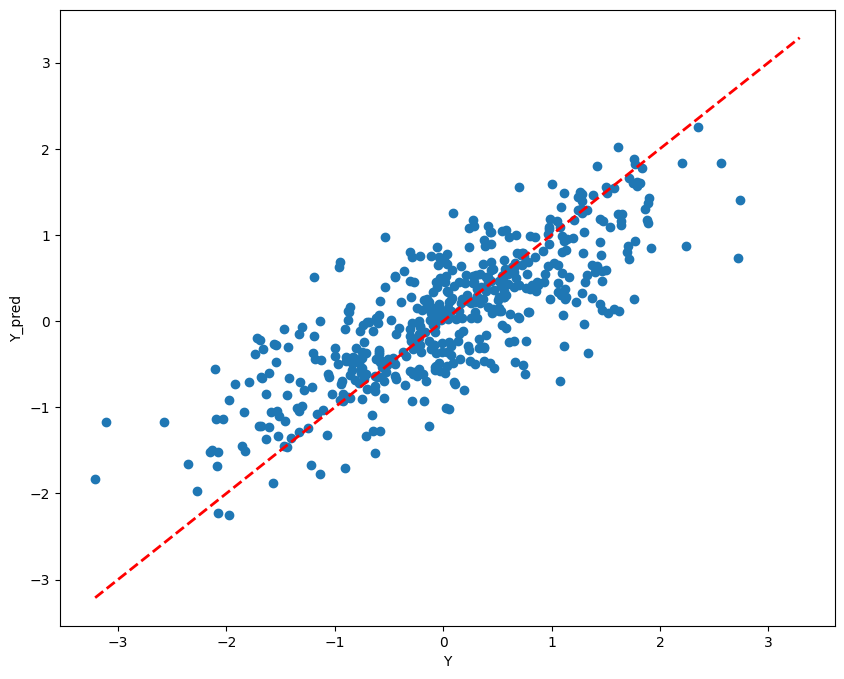

In [13]:
plt.figure(figsize=(10,8))

plt.scatter(Y[:n], Y_pred)
plt.plot([np.min(Y), np.max(Y)], [np.min(Y), np.max(Y)], ls = '--', lw = 2, c = 'r')
plt.title(r'Kriging Simple en $Y_1$')
plt.xlabel('Y')
plt.ylabel('Y_pred');

In [14]:
root_mean_squared_error(Y[:n], Y_pred)

0.6125668889791054

Co-Kriging

In [15]:
def co_kriging(x, X_1, X_2, Y, sigma):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    '''
    c = np.block([[matern_1(cdist(x, X_1)), rho_12 * np.nan_to_num(matern_12(cdist(x, X_2)), nan=1)],
                  [rho_12 * np.nan_to_num(matern_12(cdist(x, X_1)), nan=1), matern_2(cdist(x, X_2))]])
    c = np.nan_to_num(c, nan=1)
    return c @ np.linalg.solve(sigma, Y)

Leave-one-out

In [16]:
Y_pred = []
for i in range(0,n):
    sigma_aux = np.delete(np.delete(sigma, i, axis=0), i, axis=1)

    X_aux = np.delete(X_1, i, axis=0)
    Y_aux = np.delete(Y, i, axis=0)
    
    Y_pred.append(co_kriging(X_1[[i]], X_aux, X_2, Y_aux, sigma_aux))

Y_pred = np.array(Y_pred)

In [17]:
root_mean_squared_error(Y[:n], Y_pred[:,0])

0.46347078890528304

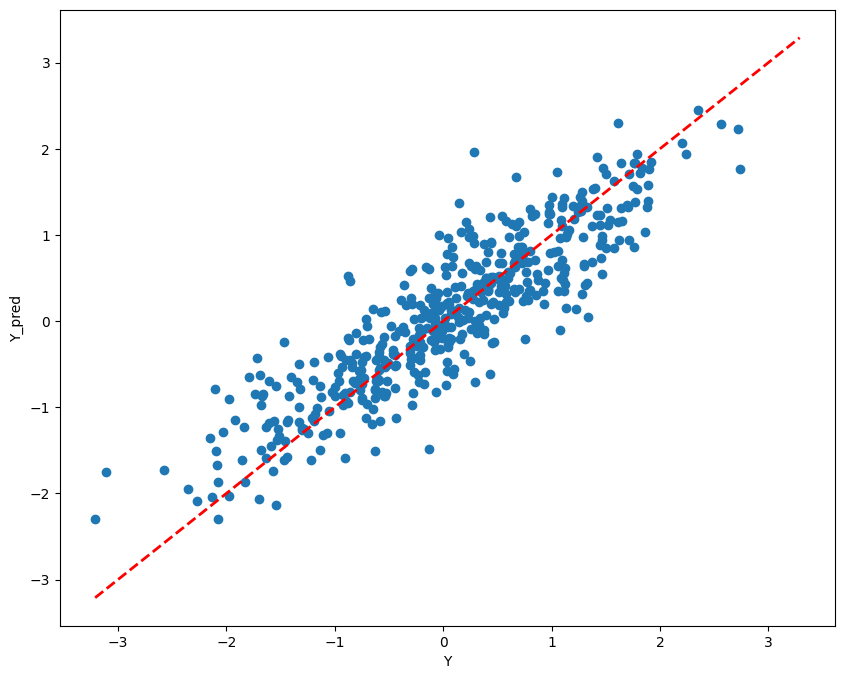

In [18]:
plt.figure(figsize=(10,8))

plt.scatter(Y[:n], Y_pred[:,0])
plt.plot([np.min(Y), np.max(Y)], [np.min(Y), np.max(Y)], ls = '--', lw = 2, c = 'r')
plt.xlabel('Y')
plt.ylabel('Y_pred');

Leave-one-out observation point

solo si $X_1 = X_2$

In [19]:
Y_pred = []
for i in range(0,n):
    sigma_aux = np.delete(np.delete(sigma, [i,i+n], axis=0), [i,i+n], axis=1)

    X_aux = np.delete(X_1, i, axis=0)
    Y_aux = np.delete(Y, [i, i+n], axis=0)
    
    Y_pred.append(co_kriging(X_1[[i]], X_aux, X_aux, Y_aux, sigma_aux))

Y_pred = np.array(Y_pred)

In [20]:
Y_1 = Y[:n]
Y_2 = Y[n:]

In [21]:
root_mean_squared_error(Y_1, Y_pred[:,0])

0.5819032795608057

In [22]:
root_mean_squared_error(Y_2, Y_pred[:,1])

0.29244457301549937

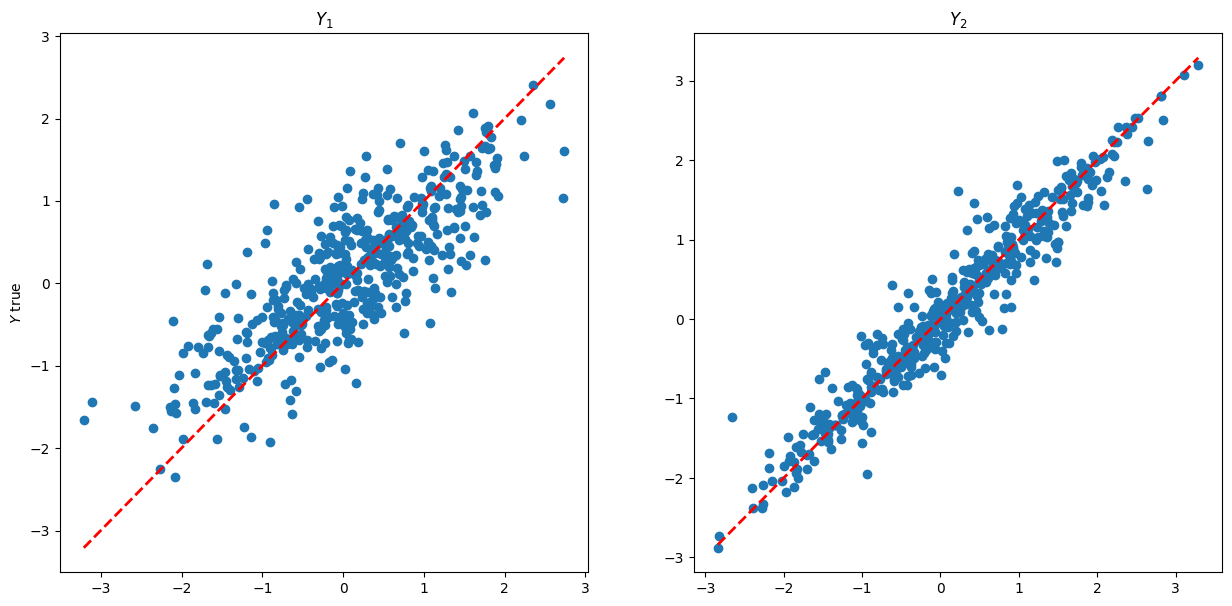

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.scatter(Y_1, Y_pred[:,0])
ax1.plot([np.min(Y_1), np.max(Y_1)], [np.min(Y_1), np.max(Y_1)], ls = '--', lw = 2, c = 'r')
ax1.set_title(r'$Y_1$')
ax1.set_ylabel(r'$Y$ true')

ax2.scatter(Y_2, Y_pred[:,1])
ax2.plot([np.min(Y_2), np.max(Y_2)], [np.min(Y_2), np.max(Y_2)], ls = '--', lw = 2, c = 'r')
ax2.set_title(r'$Y_2$');